Show how UK demand for products has evolved over time.

First, show the origins of **UK demand** -- total, the part that comes from UK manufacturing, and the part of that that actually comes from UK steel.

Then show **UK manufacturing** -- the total, then excluding imported components, then excluding imported steel products.

In [1]:
import pandas as pd
from util import load_dataframe, lighten_color

flows = load_dataframe('../build/input_data/uk-steel-model-v1.0.0.zip', 'flows')
flows['value'] = flows['value'].astype(float)

In [2]:
from palettable.cartocolors.qualitative import Prism_10, Antique_10
from palettable.colorbrewer.qualitative import Set3_7
C = Prism_10.hex_colors[1:]

colors = [
    '#555555',
    '#499dd9',
    '#cc4520',
    '#8cc425',
    '#8f1e76',
]

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rc('font', family='Myriad Pro')

In [4]:
sectors = ['4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15a', '15b', '16', '17', '18', '19', '20']

sector_ids = ['sector %s' % s for s in sectors]

sector_names = [
    'Fasteners',
    'Tools/instruments',
    'Packaging/tubes',
    'Other goods',
    'Electrical equipt.',
    'Farm machinery',
    'Dies & tooling',
    'Construct. equipt.',
    'Other equipt.',
    'Process plant',
    'Construction',
    'Vehicle bodies',
    'Drivetrains',
    'Other transport',
    'Energy industry',
    'Utilities',
    'Chemical indust.',
    'Other',
]

sector_groups = [
    ('Metal goods', ['4', '5', '6', '7']),
    ('Elec. eng', ['8']),
    ('Mech. eng', ['9', '10', '11', '12', '13']),
    ('Construction', ['14']),
    ('Transport', ['15a', '15b', '16']),
    ('Energy/water', ['17', '18', '19']),
    ('Other', ['20']),
]

In [5]:
palette = {k[0]: '#999' for k in sector_groups}
palette['Metal goods'] = C[0]
palette['Elec. eng'] = '#499dd9' # C[1]
palette['Mech. eng'] = C[2]
palette['Construction'] = '#8cc425' #C[3]
palette['Transport'] = C[4]
palette['Energy/water'] = '#cc4520' #C[5]
palette['Other'] = '#8f1e76' #C[6]

palette2 = []
for k, grp in sector_groups:
    for i in range(len(grp)):
        palette2.append(palette[k] if i % 2 else lighten_color(palette[k], 0.9))

Calculate the different parts of the flows:

In [6]:
# These are the flows from all sources into UK manufacturing
inputs = flows.query('target in @sector_ids').copy()
inputs['material'] = inputs['target'].str.lstrip('sector ')  # convert "sector 4" to just "4"
inputs = inputs.groupby(['year', 'material', 'source'])['value'].sum().unstack()

# These are the later flows of imported goods into UK demand
imported_final = flows.query('source == "product_imports"') \
    .groupby(['year', 'material'])['value'].sum()

# And these are the flows from UK manufacturing to UK demand
uk_manufac = flows.query('target == "uk_demand" and source != "product_imports"') \
    .groupby(['year', 'material'])['value'].sum()

# Collect results together
scale = (uk_manufac / inputs.sum(axis=1))
results = pd.DataFrame({
    'UK produced steel':       scale * inputs['uk_production'],
    'Imported as semis':       scale * inputs['imports'],
    'Imported as components':  scale * inputs['component_imports'],
    'Imported as final goods': imported_final,
}).fillna(0)

results_manufac = pd.DataFrame({
    'UK produced steel':       inputs['uk_production'],
    'Imported as semis':       inputs['imports'],
    'Imported as components':  inputs['component_imports'],
}).fillna(0)

# Unstack, sort sectors and convert to Mt, then unstack
results = results.reindex(sectors[::-1], level='material').unstack() / 1e3
results_manufac = results_manufac.reindex(sectors[::-1], level='material').unstack() / 1e3

results.head()

UK produced steel                                               \
material                20        19        18        17   16       15b   
year                                                                      
1980                0.6361  0.004038  0.089480  0.107543  0.0  0.099965   
1981                0.7115  0.003333  0.099824  0.119041  0.0  0.135065   
1982                0.6792  0.003133  0.097121  0.116970  0.0  0.146774   
1983                0.6304  0.002946  0.092966  0.113415  0.0  0.158273   
1984                0.7091  0.003067  0.108484  0.134005  0.0  0.198042   

                                                  ... Imported as final goods  \
material       15a        14        13        12  ...                      13   
year                                              ...                           
1980      0.070397  2.513432  0.050629  0.012818  ...                  0.1225   
1981      0.154227  2.862722  0.092900  0.022256  ...                  0.0766   
1982      0.172997  2.563794  0.076424  0.001740  ...                  0.0864   
1983      0.031066  3.112879  0.073280  0.050313  ...                  0.0881   
1984      0.044245  3.109834  0.087116  0.085870  ...                  0.1022   

                                                                          \
material      12      11      10       9       8       7       6       5   
year                                                                       
1980      0.2051  0.1285  0.0574  0.0708  0.0991  0.1286  0.0564  0.1393   
1981      0.1897  0.1129  0.0384  0.0731  0.1128  0.1298  0.0193  0.1211   
1982      0.2172  0.1298  0.0405  0.1002  0.6405  0.1402  0.0287  0.2877   
1983      0.2178  0.1377  0.0341  0.1062  0.1504  0.1527  0.0282  0.1338   
1984      0.2510  0.1549  0.0424  0.1036  0.1761  0.1750  0.0341  0.1531   

                  
material       4  
year              
1980      0.0670  
1981      0.0594  
1982      0.0792  
1983      0.0805  
1984      0.0970  

[5 rows x 72 columns]

## Figure 16: UK demand

These are the three stages we want to show:
1. UK demand supplied from domestic steel through domestic manufacturing
2. UK demand supplied from domestic manufacturing (including imported steel products and components)
3. UK demand (including imported final goods)

In [7]:
dom_demand_dom_steel = results['UK produced steel']

dom_demand = (dom_demand_dom_steel + 
              results['Imported as semis'] +
              results['Imported as components'])

all_demand = (dom_demand +
              results['Imported as final goods'])

In [8]:
def plot_stacked(df, title=None):
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.stackplot(df.index.values, df.values.T, colors=palette2[::-1]);
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlim(1980, 2016)
    ax.set_ylim(0, 20)
    ax.set_ylabel('')
    ax.set_xticks([1980, 1990, 2000, 2010])
    ax.set_yticks([0, 5, 10, 15])
    ax.set_title(title, loc='left')
    ax.grid(True)

    y1 = df.loc[2016, sectors[::-1]]
    y = 0
    for dy, name, c in zip(y1, sector_names[::-1], palette2[::-1]):
        y += dy / 2
        if dy > 0.4:
            ax.text(2016.1, y, name, va='center', color=c)
        y += dy / 2
    
    return fig, ax

def add_total_line(ax, df, title):
    """Add a line and label showing the total of another dataset."""
    ax.plot(df.index, df.sum(axis=1), 'k', lw=1.5, alpha=0.8)
    ax.text(2016.1, df.sum(axis=1).values[-1], title, va='center', fontstyle='italic')

'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


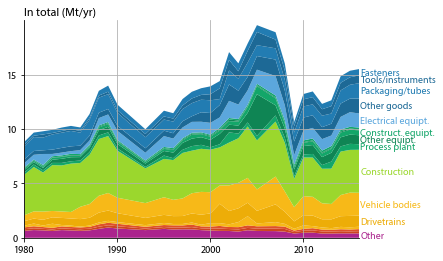

In [9]:
fig, ax = plot_stacked(all_demand, title='In total (Mt/yr)')
fig.savefig('../figures/figure16a_uk_demand_total.pdf', bbox_inches='tight')

Perhaps also only the domestically-satisfied demand, excluding imports:

'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


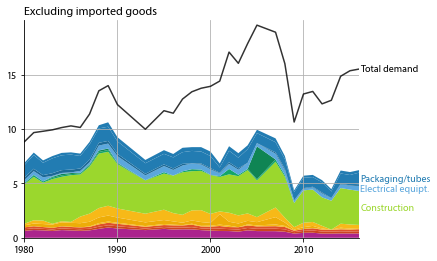

In [10]:
fig, ax = plot_stacked(dom_demand, 'Excluding imported goods')
add_total_line(ax, all_demand, 'Total demand')
fig.savefig('../figures/figure16b_uk_demand_excluding_imported_goods.pdf', bbox_inches='tight')

And now only the part of UK manufactured products that were made from UK steel

'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


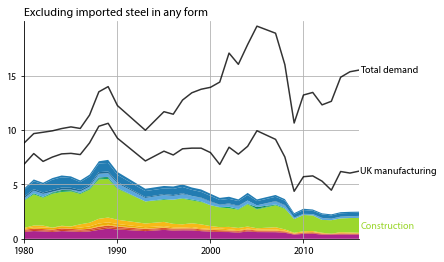

In [11]:
fig, ax = plot_stacked(dom_demand_dom_steel, title='Excluding imported steel in any form')
add_total_line(ax, all_demand, 'Total demand')
add_total_line(ax, dom_demand, 'UK manufacturing')
fig.savefig('../figures/figure16c_uk_demand_excluding_imported_steel_any_form.pdf', bbox_inches='tight')

## Figure 30: UK Manufacturing

Now show only the UK manufacturing output, in these stages:

1. All UK manufacturing
2. UK manufacturing, excluding imported components
3. UK manufacturing from UK produced steel (excluding imported components and steel products)

In [12]:
manufac_dom_steelmaking = results_manufac['UK produced steel']

manufac_dom_steel = (manufac_dom_steelmaking + 
                     results_manufac['Imported as semis'])

manufac = (manufac_dom_steel +
           results_manufac['Imported as components'])

'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


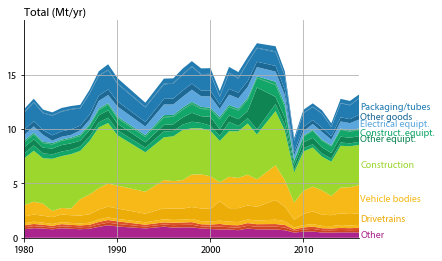

In [13]:
fig, ax = plot_stacked(manufac, title='Total (Mt/yr)')
fig.savefig('../figures/figure30a_uk_manufacturing.pdf', bbox_inches='tight')

'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


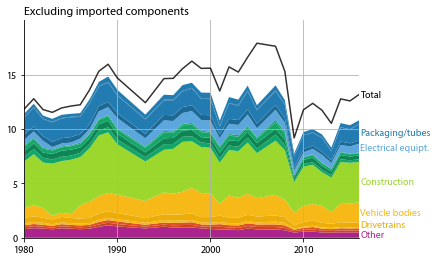

In [14]:
fig, ax = plot_stacked(manufac_dom_steel, 'Excluding imported components')
add_total_line(ax, manufac, 'Total')
fig.savefig('../figures/figure30b_uk_manufacturing_excluding_imported_components.pdf', bbox_inches='tight')

'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


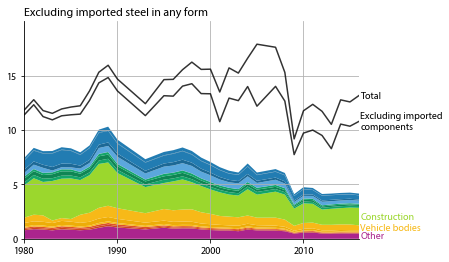

In [15]:
fig, ax = plot_stacked(manufac_dom_steelmaking, 'Excluding imported steel in any form')
add_total_line(ax, manufac, 'Total')
add_total_line(ax, manufac_dom_steel, 'Excluding imported\ncomponents')
fig.savefig('../figures/figure30c_uk_manufacturing_excluding_imported_steel_any_form.pdf', bbox_inches='tight')

## Figure 14: forms of imported steel in UK manufacturing and final consumption in 2016

'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


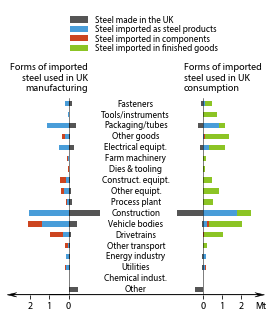

In [16]:
year = 2016

df1 = results.copy()
df2 = results_manufac.copy()

df1['UK produced steel'] *= -1
df2['UK produced steel'] *= -1

fig = plt.figure(figsize=(4, 4.2))
ax = [
    fig.add_axes([0.10, 0.06, 0.3, 0.65]),
    fig.add_axes([0.60, 0.06, 0.3, 0.65]),
]

xx = df2.loc[year].unstack(level=0).plot.barh(stacked=True, ax=ax[0], color=colors, legend=False)
df1.loc[year].unstack(level=0).plot.barh(stacked=True, ax=ax[1], color=colors, legend=False)

for a in ax:
    a.set_frame_on(False)
    a.axvline(0, color='k', lw=0.5)
    a.set_yticks([])
    a.yaxis.set_ticks_position('none')
    a.set_ylabel('')

xmax = 2.5
    
ax[0].arrow(0, -0.5, xmax+0.2, 0., fc='k', ec='k', lw = 0.5, 
            head_width=0.4, head_length=0.5, overhang=0.5, 
            length_includes_head=False, clip_on=False) 
ax[1].arrow(-8, -0.5, 8+xmax+0.2, 0., fc='k', ec='k', lw = 0.5, 
            head_width=0.4, head_length=0.5, overhang=0.5, 
            length_includes_head=False, clip_on=False) 
ax[1].text(xmax+0.2, -1.75, 'Mt')

ax[0].text(-1, 18, 'Forms of imported\nsteel used in UK\nmanufacturing', ha='right', va='bottom')
ax[1].text(-1, 18, 'Forms of imported\nsteel used in UK\nconsumption', ha='left', va='bottom')

for i, label in enumerate(sector_names[::-1]):
    ax[0].text(-3.5, i, label, ha='center', va='center', fontsize=9)

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['left'].set_visible(False)
# ax.yaxis.set_ticks_position('none')
# ax.axvline(0, ymax=1.15, color='k', lw=0.5, clip_on=False)
# ax.set_yticklabels(sector_names[::-1], fontsize=14);
ax[0].set_xticks([0, 1, 2, 3])
ax[1].set_xticks([0, 1, 2, 3])
ax[0].set_xlim(xmax, -2)
ax[1].set_xlim(-2, xmax)
# ax.set_xlabel('Mt')
# ax.set_ylabel('');
# ax.text(-0.25, 19, 'UK produced', fontsize=18, fontstyle='italic', ha='right')
# ax.text( 0.25, 19, 'Imported as...', fontsize=18, fontstyle='italic', ha='left')
fig.legend(handles=ax[1].containers,
           labels=['Steel made in the UK', 'Steel imported as steel products', 'Steel imported in components',
                   'Steel imported in finished goods'],
           frameon=False,
           loc='lower center',
           bbox_to_anchor=(0.5, 0.85),
           labelspacing=0.05,
           fontsize=9)

fig.savefig('../figures/figure14_forms_of_imported_steel.pdf')

## Comparing UK steel output to UK final demand

'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'MyriadPro-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


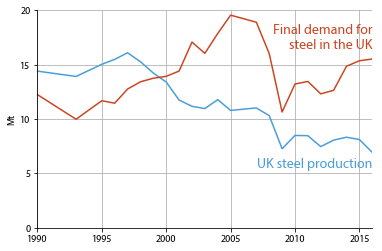

In [17]:
production = flows.query('source == "uk_production"').groupby('year')['value'].sum() / 1e3

demand_check = flows.query('target == "uk_demand"').groupby('year')['value'].sum() / 1e3
assert abs(demand_check - all_demand.sum(axis=1)).max() < 1e-10

fig, ax = plt.subplots();
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Mt')
production.plot(color=colors[1]);
demand_check.plot(color=colors[2]);
ax.set_xlabel('')
plt.xlim(1990, 2016);
plt.ylim(0, 20);
ax.set_yticks([0, 5, 10, 15, 20])
ax.grid(True)
ax.annotate('UK steel production', (2016, 5.5), ha='right', fontsize=14, color=colors[1])
ax.annotate('Final demand for\nsteel in the UK', (2016, 16.5), ha='right', fontsize=14, color=colors[2])
fig.savefig('../figures/figure12_output_and_final_demand.pdf', bbox_inches='tight')

In [18]:
pd.DataFrame({
    'UK steel production': production,
    'Steel in UK final demand': demand_check,
}).to_csv('../figures/figure12_output_and_final_demand.csv')